In [1]:
import sys
import os

import numpy as np
import cv2
import torch
from torch.utils.data import DataLoader
from torchvision import models
from skimage import io
from skimage.transform import resize

sys.path.insert(0, os.path.abspath('..'))

from src.models.gradcam.grad_cam_pipeline import GradCamPipeline
from src.utils.load_cfg import ConfigLoader
from src.factories import ModelFactory
from src.factories import DatasetFactory
from src.utils.misc import MiscUtils

import matplotlib.pyplot as plt
%matplotlib inline


model_cfg = '../configs/model_cfgs/pipeline_rgbspec_san19pair_gruhallu.yaml'
dataset_cfg = '../configs/dataset_cfgs/epickitchens_short.yaml'
train_cfg = '../configs/train_cfgs/train_san_short.yaml'

weight = '../saved_models/rnn_hallu_epoch_00099.model'

In [2]:
# Load configurations
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(dataset_cfg)
train_params = ConfigLoader.load_train_cfg(train_cfg)

dataset_params.update({
    'modality': model_params['modality'],
    'num_segments': model_params['num_segments'],
    'new_length': model_params['new_length'],
})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build model
model_factory = ModelFactory()
model = model_factory.generate(model_name, device=device, model_factory=model_factory, **model_params)
model.load_model(weight)
model = model.to(device)

# Get training augmentation and transforms
train_augmentation = MiscUtils.get_train_augmentation(model.modality, model.crop_size)
train_transform, val_transform = MiscUtils.get_train_val_transforms(
    modality=model.modality,
    input_mean=model.input_mean,
    input_std=model.input_std,
    scale_size=model.scale_size,
    crop_size=model.crop_size,
    train_augmentation=train_augmentation,
)

# Data loader
dataset_factory = DatasetFactory()
loader_params = {
    'batch_size': train_params['batch_size'],
    'num_workers': train_params['num_workers'],
    'pin_memory': True,
}

val_dataset = dataset_factory.generate(dataset_name, mode='val', transform=val_transform, **dataset_params)
val_loader = DataLoader(val_dataset, shuffle=False, **loader_params)

SANMulti(
  (rgb): SAN(
    (conv_in): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn_in): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer0): Sequential(
      (0): Bottleneck(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (sam): SAM(
          (conv1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
          (conv2): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
          (conv3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          (conv_w): Sequential(
            (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(6, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (3): BatchNorm2d(4,

GRUHallu(
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (rnn): GRU(1024, 1024, num_layers=2, batch_first=True)
  (fc_hallu): Linear(in_features=1024, out_features=6272, bias=True)
  (fc_verb): Linear(in_features=1024, out_features=125, bias=True)
  (fc_noun): Linear(in_features=1024, out_features=352, bias=True)
)
Pipeline(
  (light_model): SANMulti(
    (rgb): SAN(
      (conv_in): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_in): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layer0): Sequential(
        (0): Bottleneck(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (sam): SAM(
  

In [3]:
# Deprocess data for visualization
def deprocess_rgb(rgb):
    rgb = rgb.cpu().numpy()
    assert rgb.shape[0] == 1
    _, _, h, w = rgb.shape
    rgb = rgb.reshape([model.num_segments, 3, h, w]).transpose(0, 2, 3, 1)
    rgb *= 1  # std
    rgb += np.array([104, 117, 128])  # mean
    rgb = rgb.astype(np.uint8)
    return rgb


def deprocess_spec(spec):
    spec = spec.cpu().numpy()
    assert spec.shape[0] == 1
    _, _, h, w = spec.shape
    spec = spec.reshape([model.num_segments, h, w])
    return spec

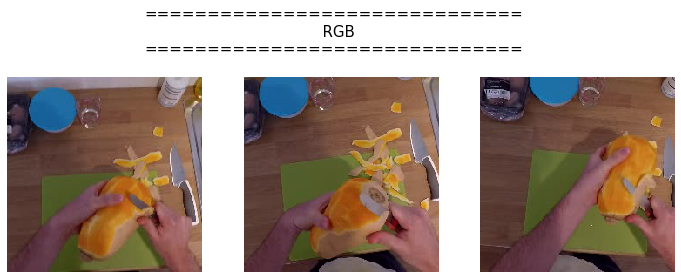

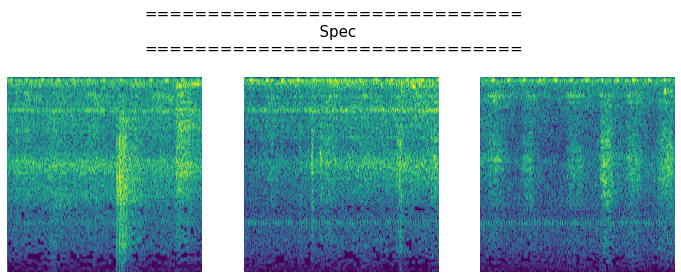

In [4]:
# Get a single batch of data
# sample_id = 4
# sample_id = 35
sample_id = 64
for i, (sample, target) in enumerate(val_loader):
    sample = {k: v.to(device) for k, v in sample.items()}
    target = {k: v.to(device) for k, v in target.items()}

    if i == sample_id:
        break
    
# Deprocess inputs
rgb = deprocess_rgb(sample['RGB'])
spec = deprocess_spec(sample['Spec'])

# Display input RGB
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
fig.suptitle('='*30+'\n  RGB\n'+'='*30, fontsize=15)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
for i in range(model.num_segments):
    axes[i].imshow(cv2.cvtColor(rgb[i], cv2.COLOR_BGR2RGB))
    axes[i].axis('off')

# Display input Spec
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
fig.suptitle('='*30+'\n  Spec\n'+'='*30, fontsize=15)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
for i in range(model.num_segments):
    axes[i].imshow(spec[i])
    axes[i].axis('off')

In [5]:
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

model.eval()
output = model(sample)

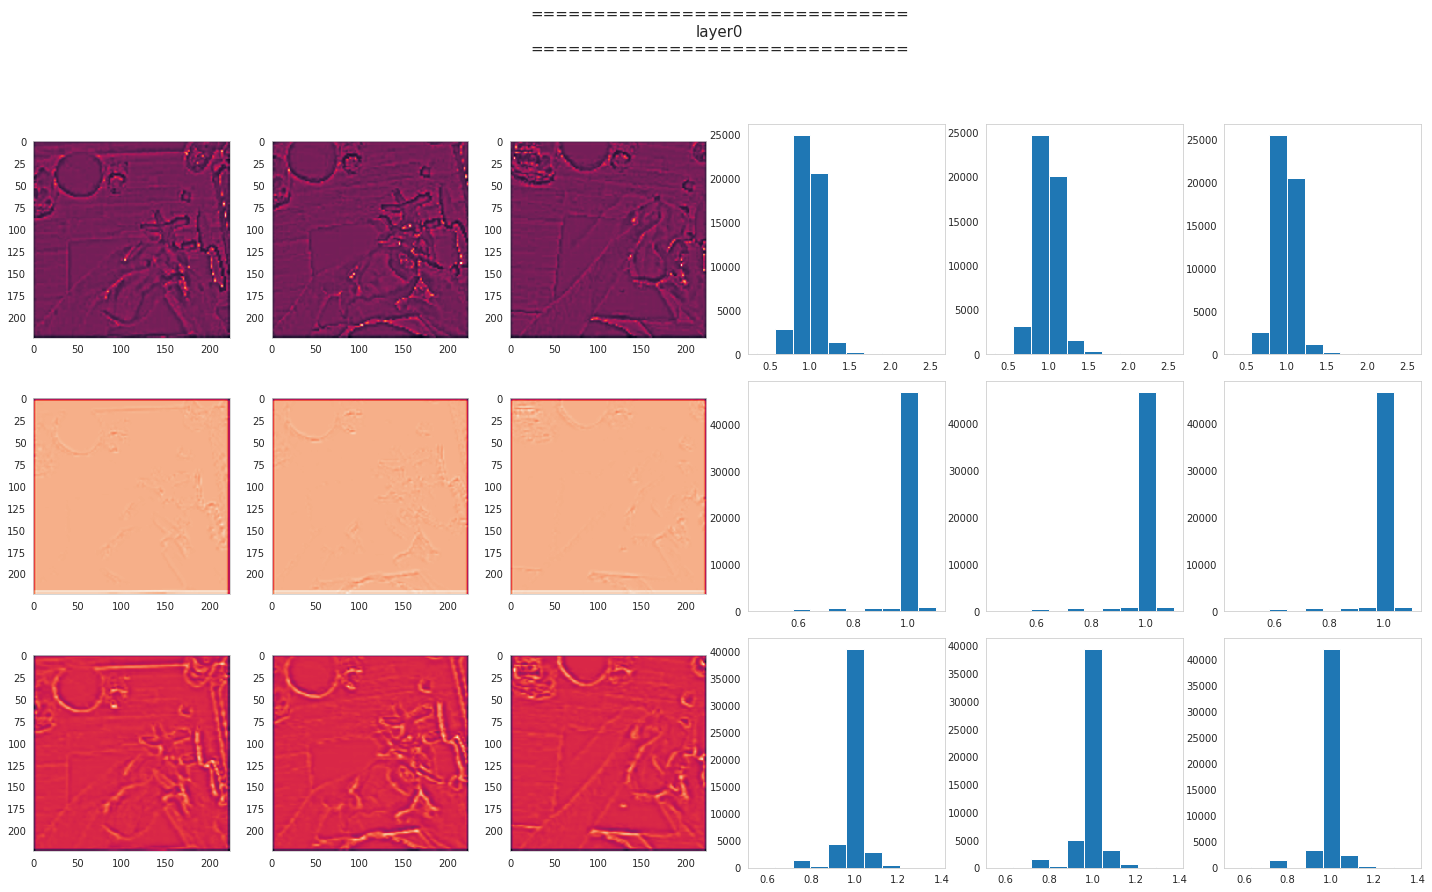

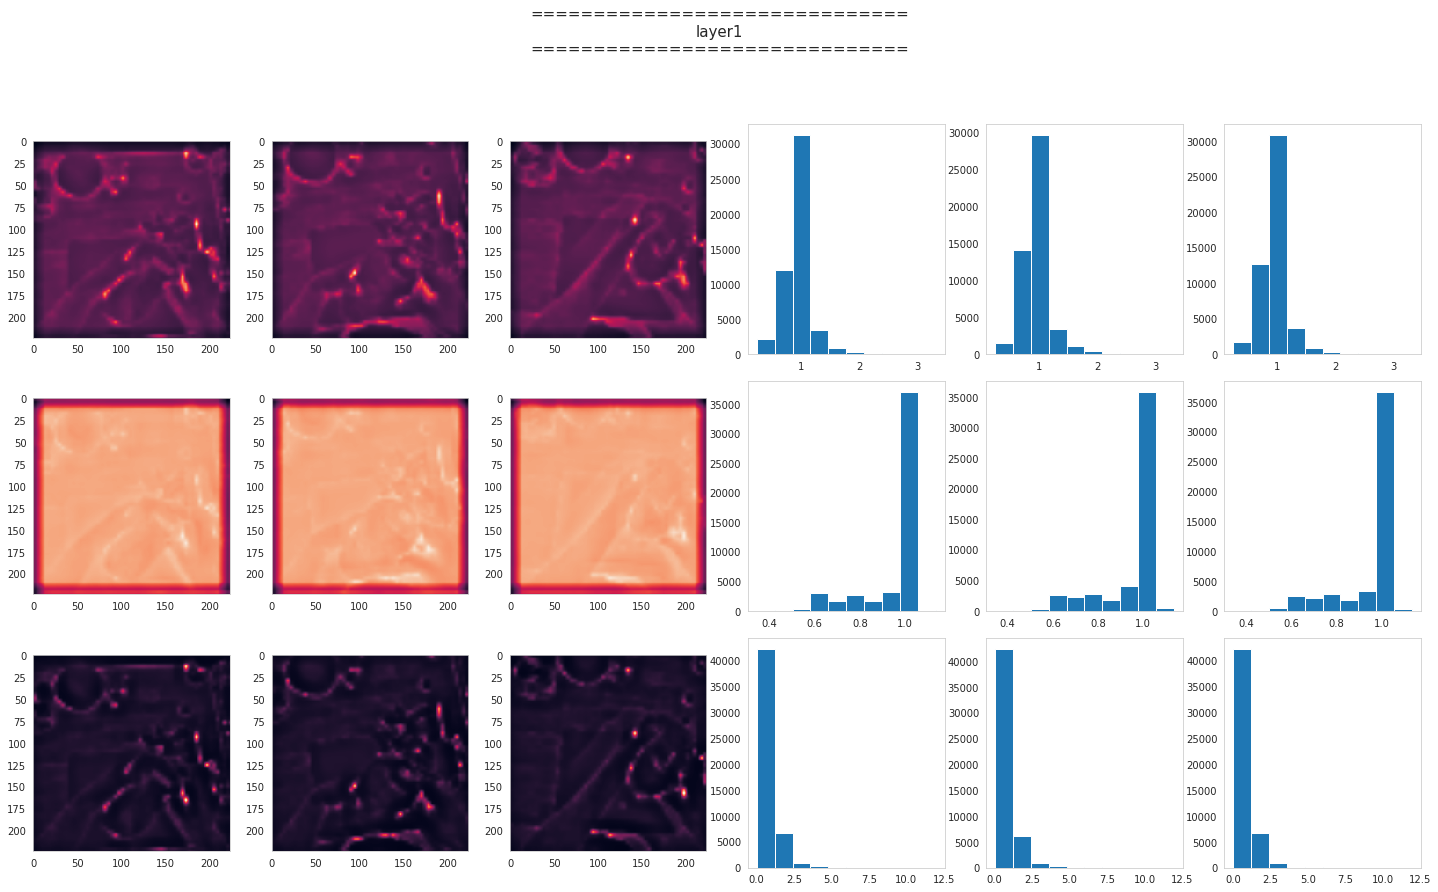

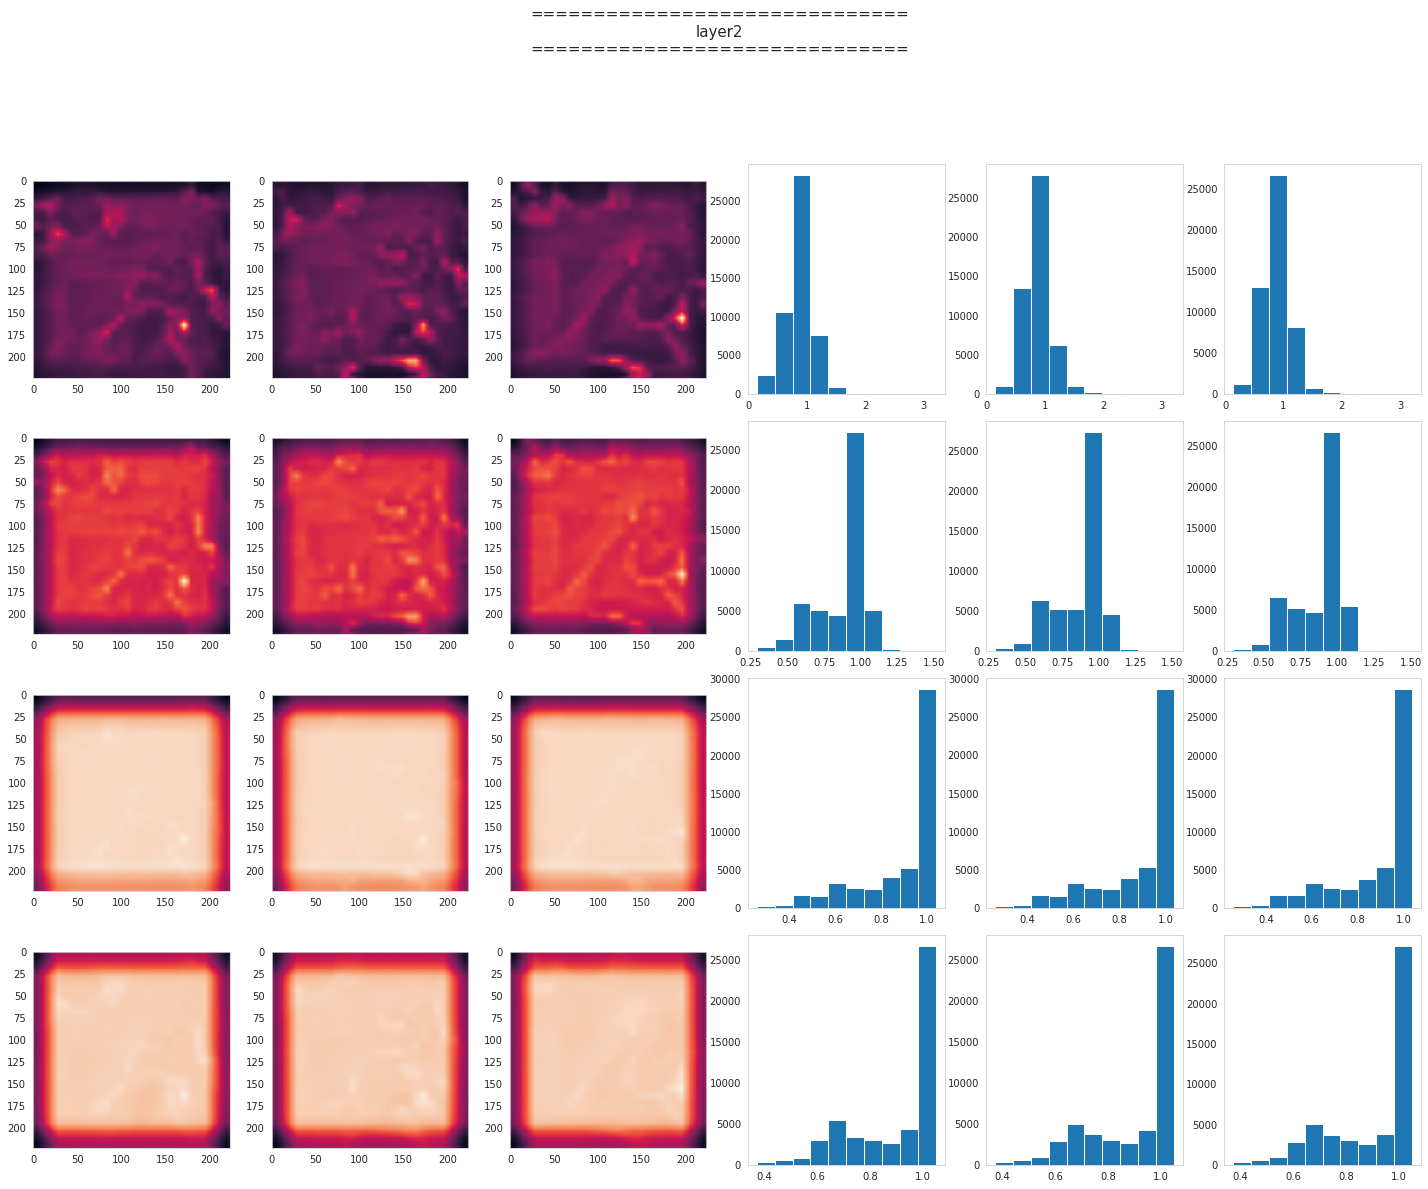

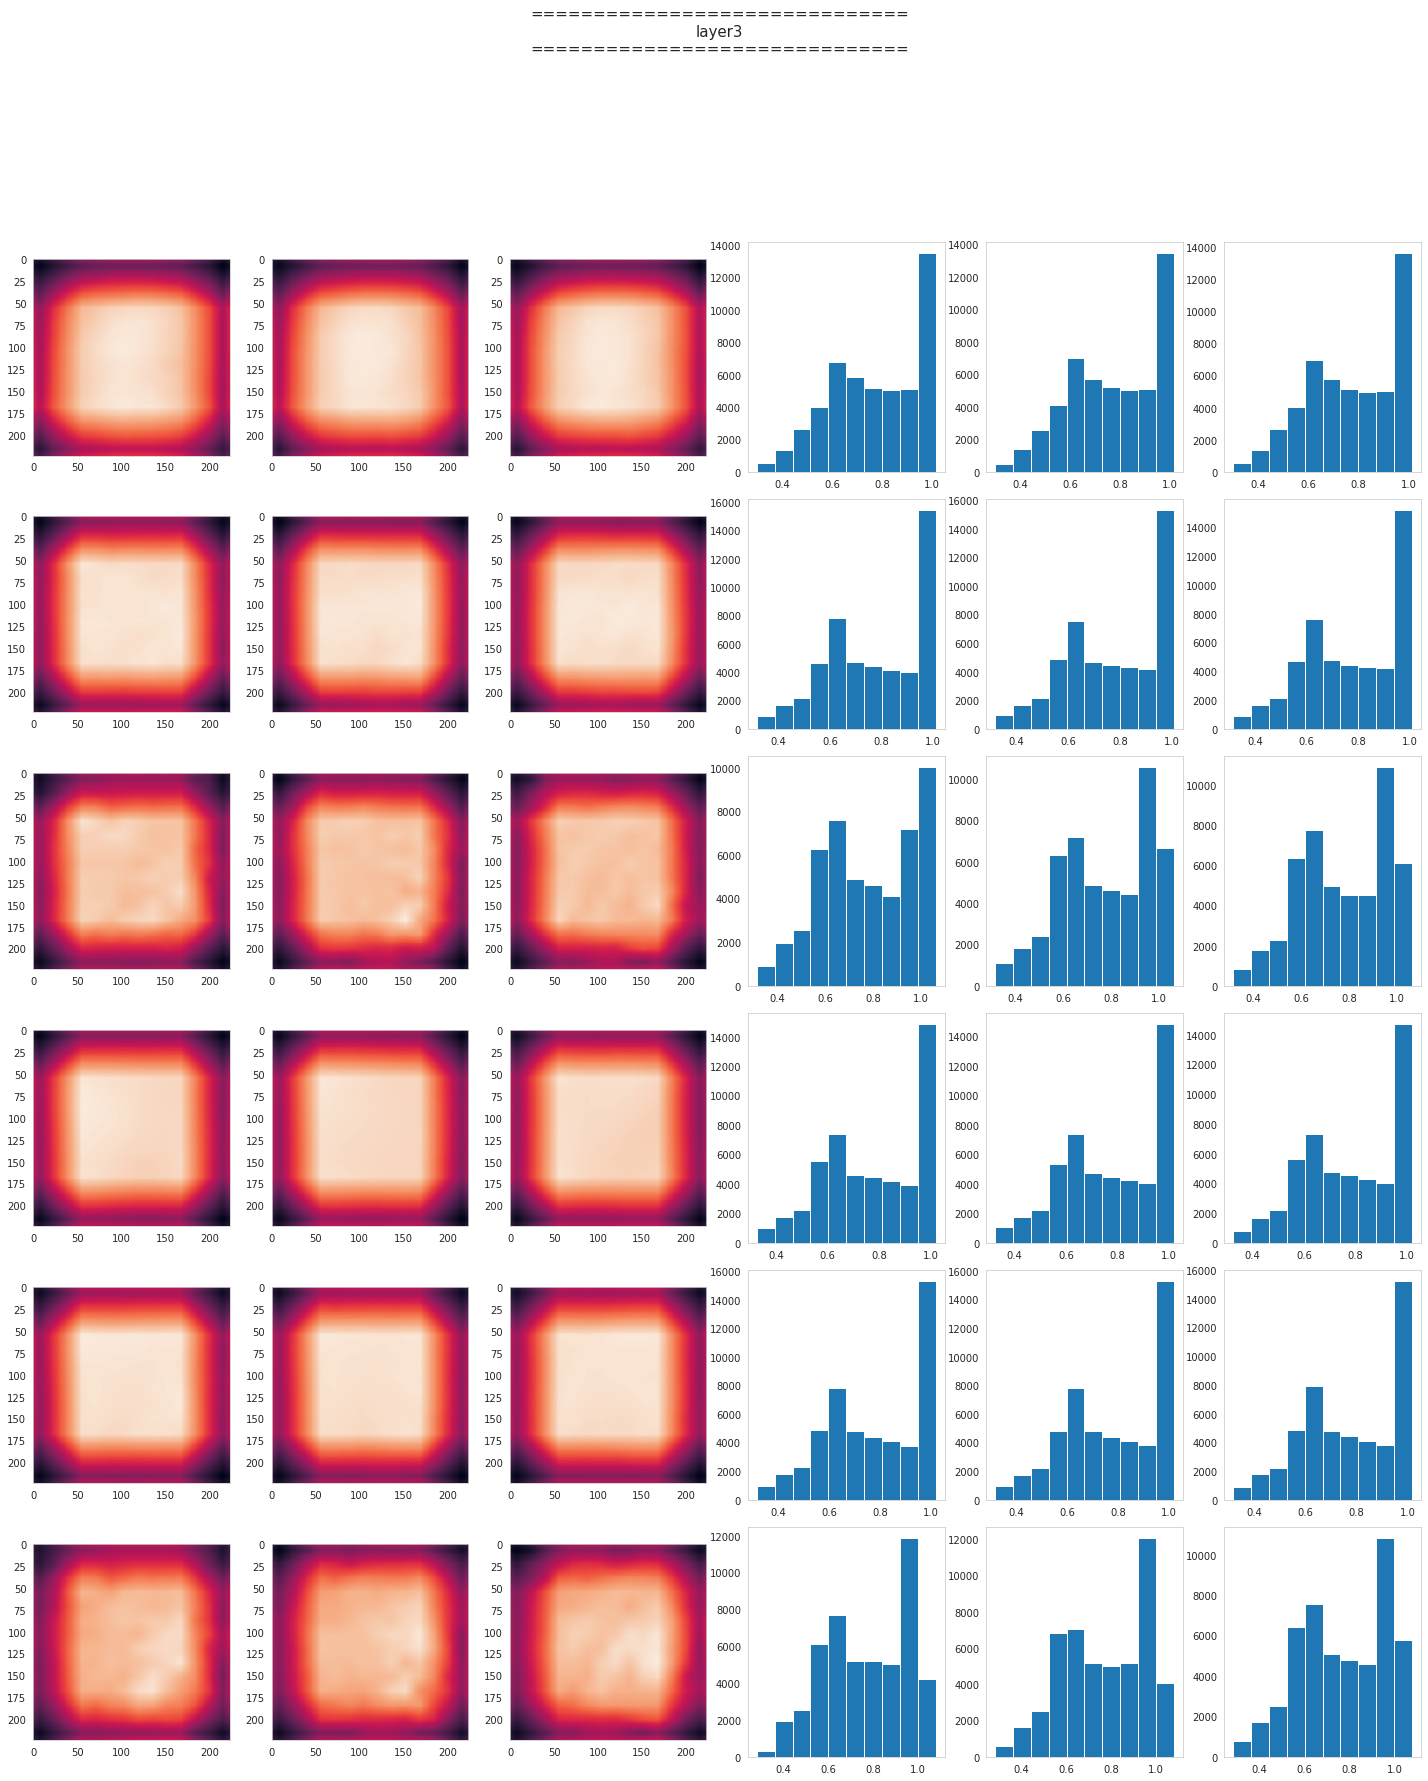

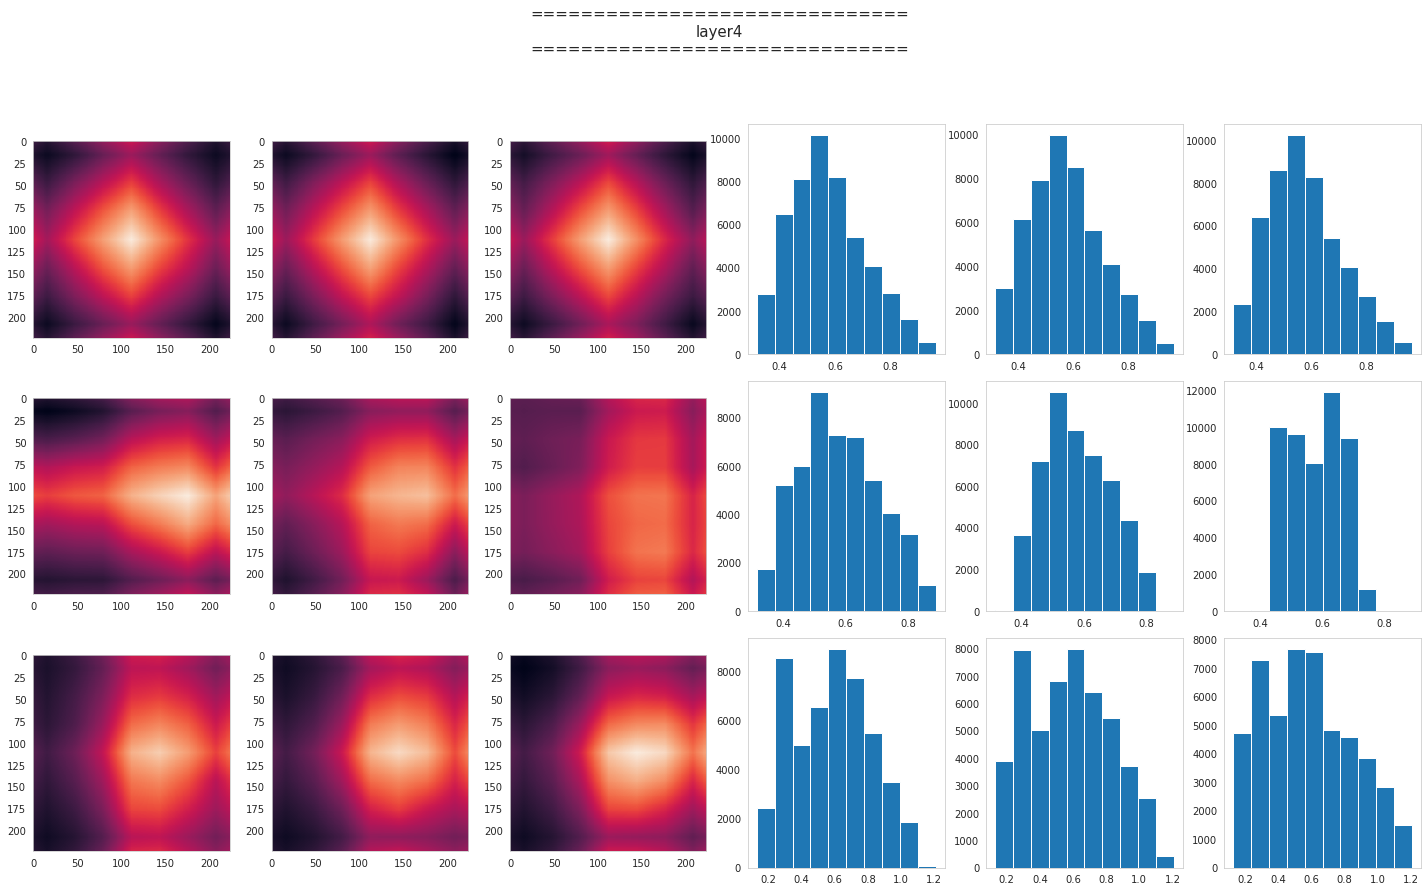

In [9]:
l_name_lst = ['layer0', 'layer1', 'layer2', 'layer3', 'layer4']
m_name_len = [3, 3, 4, 6, 3] # SAN19
attn_dict = model.light_model.rgb.get_all_attention_weights(aggregated=True)
    
# Plot the attention
for i, l_name in enumerate(l_name_lst):
    fig, axes = plt.subplots(m_name_len[i], model.num_segments*2,
                             figsize=(20, m_name_len[i]*4.2))
    fig.suptitle('='*30+'\n{}\n'.format(l_name)+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)

    for j in range(m_name_len[i]):
        m_name = str(j)
        att = attn_dict[l_name][m_name].cpu().detach().numpy()

        # Get the mean for visualization
        att = att.mean(axis=1)

        # Resize the image
        att = np.array([resize(x, (224, 224), preserve_range=True) for x in att])

        # Plot
        vmin, vmax = att.min(), att.max()
        for t in range(model.num_segments):
            if len(axes.shape) == 1:
                axes[t].imshow(att[t], vmin=vmin, vmax=vmax)
                axes[t+model.num_segments].hist(att[t].flatten(), range=[vmin, vmax])
            else:
                axes[j, t].imshow(att[t], vmin=vmin, vmax=vmax)
                axes[j, t+model.num_segments].hist(att[t].flatten(), range=[vmin, vmax])

torch.Size([3, 32, 14, 14]) torch.Size([3, 32, 14, 14])


Text(0, 0.5, 'hallucination')

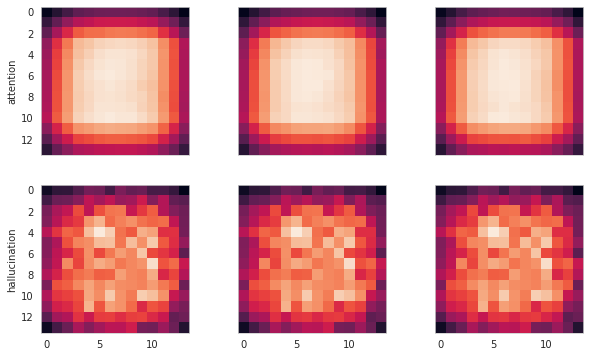

In [21]:
attn = model._attn[0]
hallu = model._hallu[0]
print(attn.shape, hallu.shape)

fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)
for t in range(3):
    axes[0, t].imshow(attn[t].mean(dim=0).cpu().detach().numpy())
    axes[1, t].imshow(hallu[t].mean(dim=0).cpu().detach().numpy())
axes[0, 0].set_ylabel('attention')
axes[1, 0].set_ylabel('hallucination')